In [1]:
import numpy as np
import wimprates
import inference_interface
import os
import matplotlib.pyplot as plt
import json
from pathlib import Path
from tqdm import tqdm
import importlib.resources
from scipy.interpolate import RegularGridInterpolator
from inference_interface import template_to_multihist
from blueice.utils import arrays_to_grid
import scipy.stats as stats
from scipy.interpolate import interp1d
from appletree.utils import load_json

/home/shenyangshi/.local/lib/python3.9/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


XLA_PYTHON_CLIENT_PREALLOCATE is set to false
XLA_PYTHON_CLIENT_ALLOCATOR is set to platform
Using aptext package from https://github.com/XENONnT/applefiles


/home/shenyangshi/.local/lib/python3.9/site-packages/appletree/__init__.py:51: UserWarning: You are running appletree on CPU, which usually results in low performance.
  warn(warning)


# 1. Make template for a 6 GeV WIMP with analysis yield model

In [2]:
# Initalize fast simulation object
from light_wimp_data_release import Template
template = Template()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [4]:
# Load yield model curve
path = '../light_wimp_data_release/data/'
yield_model = {
    'ly': load_json(path + "signal/nr_ly_ybe_only_median_sr0_cevns.json"),
    'qy': load_json(path + "signal/nr_qy_ybe_only_median_sr0_cevns.json")
}

In [5]:
# Load 6 geV spectrum
wimp_spectrum = load_json(path + f"signal/wimp_si_spectrum_3.json")

In [6]:
# Perform fast simulation
wimp_template = template.build_template(wimp_spectrum, yield_model)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3197 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/3202 [00:00<?, ?it/s]

In [7]:
# Load officlal template used in the analysis
template_6geV = dict()
for sr in ['sr0', 'sr1']:
    template_6geV[sr] = template_to_multihist(path + f'wimp_si/template_XENONnT_{sr}_wimp_si_3_cevns_tly_0.0_tqy_0.0.h5')['template']

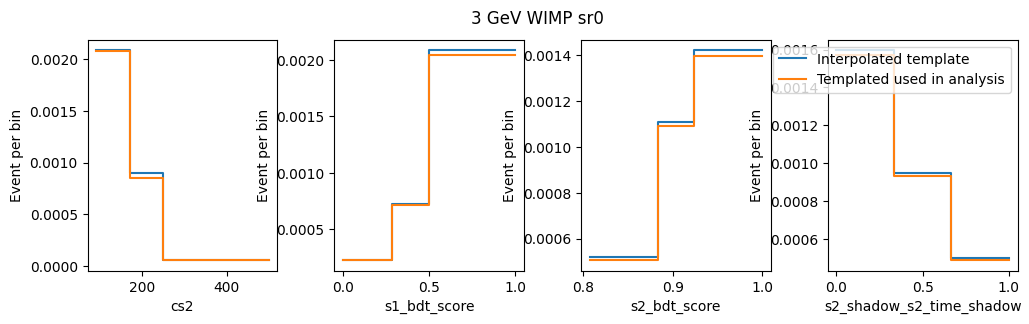

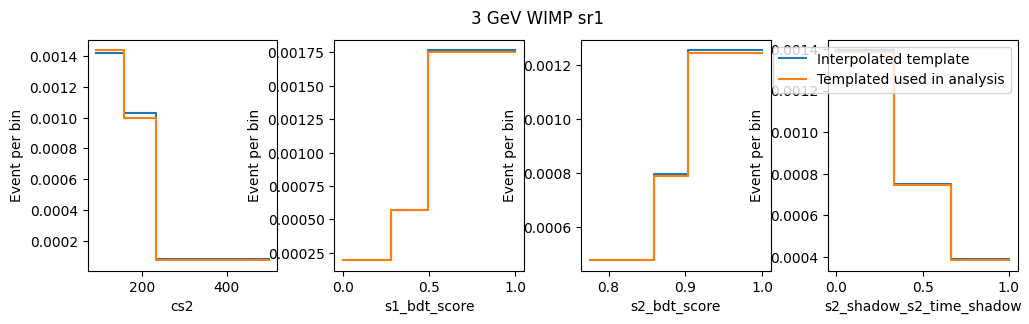

In [8]:
# Compared data released templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        wimp_template[sr].project(axis=axis).plot(label='Interpolated template',)
        template_6geV[sr].project(axis=axis).plot(label='Templated used in analysis')
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    fig.suptitle(f'3 GeV WIMP {sr}')
    plt.show()

# 2. Make template for a custom signal model using a custom yield model

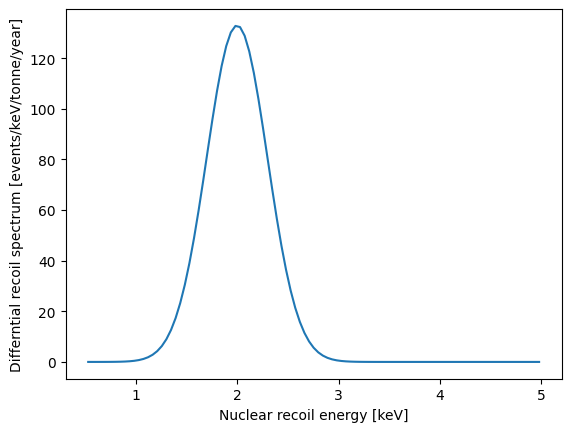

In [9]:
# Signal spectrum, let's assume a mono-energetic line at 2 keV

ek = np.linspace(0.51, 5, 100)
ek_bin_center = (ek[1:] + ek[:-1]) / 2
ek_bin_width = np.diff(ek_bin_center)[0]

mu, sigma = 2, 0.3
rate = 100
dr_dek = stats.norm.pdf(ek_bin_center, mu, sigma)

cdf = np.cumsum(ek_bin_width * dr_dek)

plt.plot(ek_bin_center, dr_dek / cdf[-1] * rate)
plt.xlabel('Nuclear recoil energy [keV]')
plt.ylabel('Differntial recoil spectrum [events/keV/tonne/year]')
plt.show()


# Then the file we input is:
custom_spectrum = dict()
custom_spectrum['coordinate_system'] = [0.0] + (cdf / cdf[-1]).tolist()
custom_spectrum['coordinate_name'] = 'cdf'
custom_spectrum['map'] = ek.tolist()
custom_spectrum['rate'] = rate

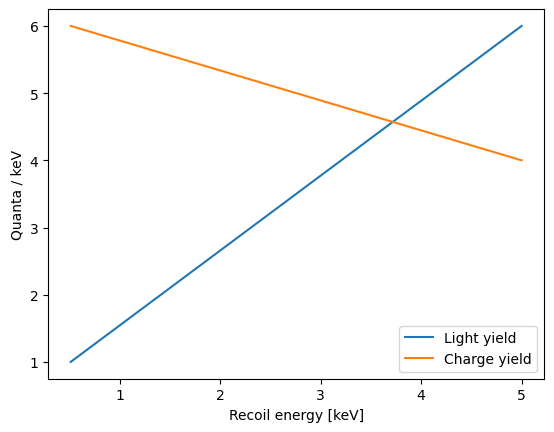

In [10]:
# Let's assume simple LY and QY curve for simplicity, note the ly and qy cannot excced interpolation bounds!

custom_yield_model = dict()
custom_yield_model['ly'] = dict(coordinate_system = np.linspace(0.51, 5, 100).tolist(),
                                map = np.linspace(1, 6, 100).tolist())
custom_yield_model['qy'] = dict(coordinate_system = np.linspace(0.51, 5, 100).tolist(),
                                map = np.linspace(6, 4, 100).tolist())

plt.plot(custom_yield_model['ly']['coordinate_system'],custom_yield_model['ly']['map'], label='Light yield')
plt.plot(custom_yield_model['qy']['coordinate_system'],custom_yield_model['qy']['map'], label='Charge yield')
plt.xlabel('Recoil energy [keV]')
plt.ylabel('Quanta / keV')
plt.legend()
plt.show()


In [11]:
# Build templates
custom_template = template.build_template(custom_spectrum, custom_yield_model)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

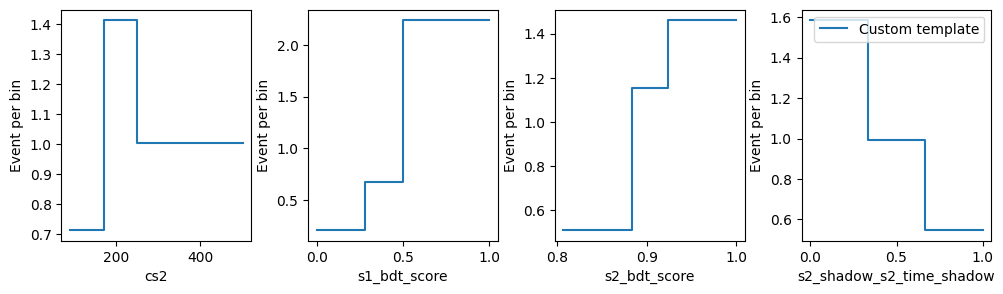

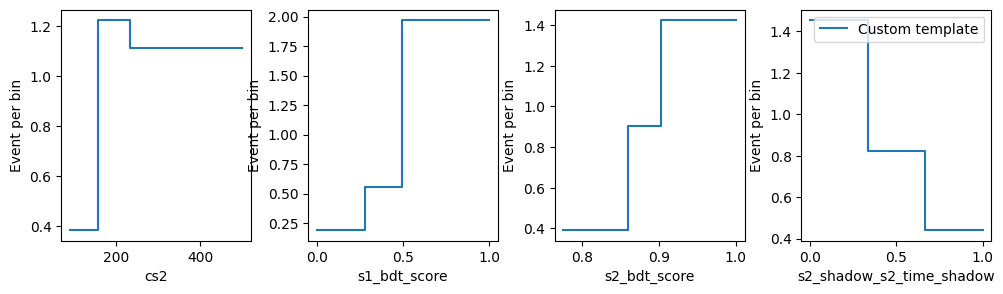

In [12]:
# Plot templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        custom_template[sr].project(axis=axis).plot(label='Custom template',)
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    plt.show()

In [13]:
# Now you have the tools to generate any signal with any of signal of interest spectrum and yield model in your mind!
# If you feel like using XENONnT default yield model, it's easier

In [14]:
# Build templates
custom_template = template.build_template(custom_spectrum, yield_model=None)

SR:   0%|          | 0/2 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

Basis interpolation:   0%|          | 0/20000 [00:00<?, ?it/s]

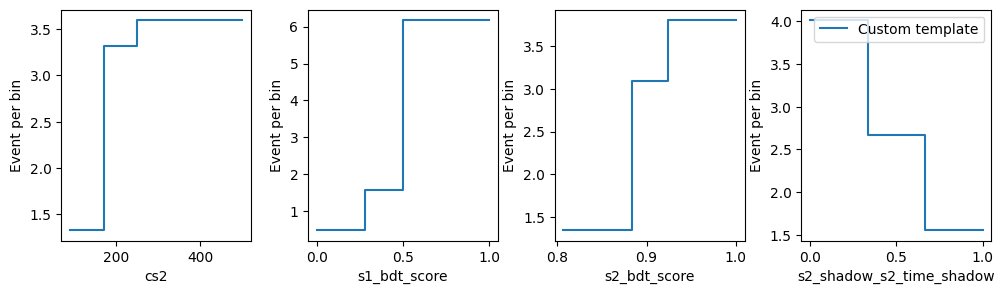

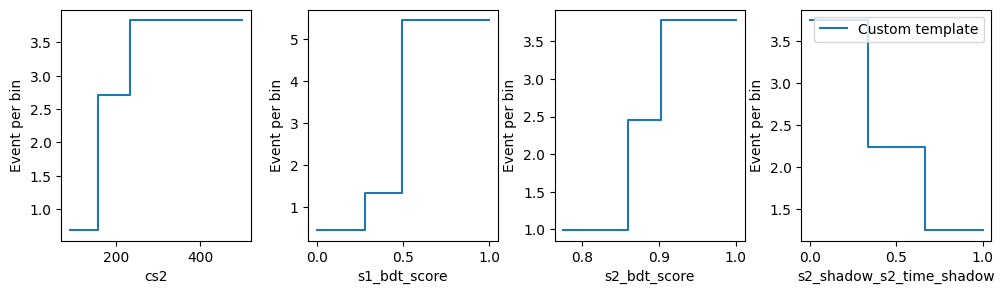

In [15]:
# Plot templates

for sr in ['sr0', 'sr1']:

    fig = plt.figure(figsize=(12, 3))
    grid = plt.GridSpec(1, 4, wspace=0.3)
    
    for i, axis in enumerate(['cs2', 's1_bdt_score', 's2_bdt_score', "s2_shadow_s2_time_shadow"]):
    
        plt.subplot(grid[i])
        
        custom_template[sr].project(axis=axis).plot(label='Custom template',)
        plt.xlabel(axis)
        plt.ylabel('Event per bin')

    plt.legend(loc=1)
    plt.show()